In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
df = pd.read_csv('../data/data.csv')
df.head()

,Unnamed: 0,time,temp,rain,wind(m/s),wind_dir,humidity,hPa,snow,mR/h
0,0,2019-01-01 00:00:00,-4.9,0.0,0.4,0,62,1026.9,0.0,0.0105
1,1,2019-01-01 01:00:00,-4.4,0.0,0.6,90,61,1026.7,0.0,0.0106
2,2,2019-01-01 02:00:00,-3.9,0.0,0.4,0,59,1026.7,0.0,0.0106
3,3,2019-01-01 03:00:00,-4.4,0.0,1.0,200,61,1027.2,0.0,0.0106
4,4,2019-01-01 04:00:00,-5.1,0.0,0.7,320,66,1026.7,0.0,0.0105


In [5]:
# time 컬럼의 문자열 데이터를 datetime 타입으로 변환하여 타임스탬프 값으로 변환
df['time'] = pd.to_datetime(df['time']).apply(lambda x: x.timestamp())

In [6]:
scaler = MinMaxScaler()

scale_cols = ['temp','rain','wind(m/s)','wind_dir','humidity','hPa','snow','mR/h']
scaled_df = scaler.fit_transform(df[scale_cols])

scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)
print(scaled_df)

          temp  rain  wind(m/s)  wind_dir  humidity       hPa  snow      mR/h
0     0.099558   0.0   0.037736  0.000000  0.600000  0.930233   0.0  0.109375
1     0.110619   0.0   0.056604  0.250000  0.588889  0.926004   0.0  0.125000
2     0.121681   0.0   0.037736  0.000000  0.566667  0.926004   0.0  0.125000
3     0.110619   0.0   0.094340  0.555556  0.588889  0.936575   0.0  0.125000
4     0.095133   0.0   0.066038  0.888889  0.644444  0.926004   0.0  0.109375
...        ...   ...        ...       ...       ...       ...   ...       ...
8732  0.267699   0.0   0.311321  0.694444  0.688889  0.733615   0.0  0.062500
8733  0.241150   0.0   0.301887  0.694444  0.722222  0.750529   0.0  0.062500
8734  0.214602   0.0   0.405660  0.694444  0.677778  0.769556   0.0  0.078125
8735  0.205752   0.0   0.349057  0.750000  0.644444  0.780127   0.0  0.078125
8736  0.199115   0.0   0.320755  0.694444  0.711111  0.782241   0.0  0.078125

[8737 rows x 8 columns]


In [7]:
feature_cols = ['temp','rain','wind(m/s)','wind_dir','humidity','hPa','snow']
result_cols = ['mR/h']

result_df = pd.DataFrame(scaled_df, columns=result_cols)
feature_df = pd.DataFrame(scaled_df, columns=feature_cols)

result_np = result_df.to_numpy()
feature_np = feature_df.to_numpy()

In [8]:
def make_sequence_dataset(feature, result, window_size):
    feature_list = []
    result_list = []
    
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size])
        result_list.append(result[i+window_size])
        
    return np.array(feature_list), np.array(result_list)

In [9]:
window_size = 40
X,Y = make_sequence_dataset(feature_np, result_np, window_size)
print(X.shape, Y.shape)

(8697, 40, 7) (8697, 1)


In [10]:
split = -400
X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(8297, 40, 7) (8297, 1)
(400, 40, 7) (400, 1)


In [11]:
X_train = X_train.reshape((X_train.shape[0], -1))  # (8297, 40*7)
X_test = X_test.reshape((X_test.shape[0], -1))  # (400, 40*7)

# One-Class SVM 모델 생성 및 학습
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)

# 새로운 데이터가 이상치인지 판단
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Train set 정상 데이터의 개수:", len(y_pred_train[y_pred_train == 1]))
print("Train set 비정상 데이터의 개수:", len(y_pred_train[y_pred_train == -1]))
print("Test set 정상 데이터의 개수:", len(y_pred_test[y_pred_test == 1]))
print("Test set 비정상 데이터의 개수:", len(y_pred_test[y_pred_test == -1]))

Train set 정상 데이터의 개수: 7457
Train set 비정상 데이터의 개수: 840
Test set 정상 데이터의 개수: 400
Test set 비정상 데이터의 개수: 0


In [18]:
y_true = np.ones(len(y_pred_train))
y_true[y_true == -1] = 0

tn, fp, fn, tp = confusion_matrix(y_true, y_pred_train).ravel()

# Compute metrics
accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2 * precision * recall / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

Accuracy: 0.8987585874412438
Precision: 1.0
Recall: 0.8987585874412438
F1-score: 0.9466802082010918


In [33]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], -1))  # (8297, 40, 7)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], -1))  # (400, 40, 7)

In [63]:
model = Sequential([
    LSTM(128, activation = 'tanh', input_shape = X_train[0].shape),
    Dropout(0.5),
    Dense(1, activation = 'linear')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [64]:
# 랜덤 시드 지정
np.random.seed(5210)
# 모델 컴파일
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# ModelCheckpoint 콜백 생성
checkpoint = ModelCheckpoint('ad_model.h5', monitor='val_loss', save_best_only=True)

# 모델 학습
history = model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test), callbacks=[checkpoint],batch_size=10)


Epoch 1/50
830/830 [==============================] - 13s 13ms/step - loss: 0.0054 - mae: 0.0471 - val_loss: 0.0028 - val_mae: 0.0453
Epoch 2/50
830/830 [==============================] - 10s 12ms/step - loss: 0.0050 - mae: 0.0443 - val_loss: 0.0019 - val_mae: 0.0352
Epoch 3/50
830/830 [==============================] - 10s 12ms/step - loss: 0.0049 - mae: 0.0435 - val_loss: 0.0019 - val_mae: 0.0340
Epoch 4/50
830/830 [==============================] - 10s 12ms/step - loss: 0.0049 - mae: 0.0433 - val_loss: 0.0019 - val_mae: 0.0349
Epoch 5/50
830/830 [==============================] - 11s 13ms/step - loss: 0.0048 - mae: 0.0426 - val_loss: 0.0019 - val_mae: 0.0354
Epoch 6/50
830/830 [==============================] - 10s 12ms/step - loss: 0.0046 - mae: 0.0420 - val_loss: 0.0017 - val_mae: 0.0332
Epoch 7/50
830/830 [==============================] - 10s 12ms/step - loss: 0.0045 - mae: 0.0416 - val_loss: 0.0027 - val_mae: 0.0449
Epoch 8/50
830/830 [==============================] - 10s 12ms

In [65]:
loss, mae = model.evaluate(X_test, Y_test)
print('Test MSE: {:.5f}'.format(loss))
print('Test MAE: {:.5f}'.format(mae))

13/13 [==============================] - 1s 12ms/step - loss: 0.0016 - mae: 0.0299
Test MSE: 0.00156
Test MAE: 0.02990


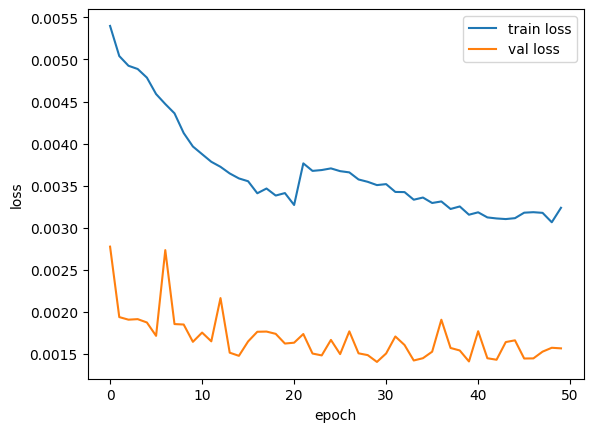

In [66]:
# 로스 감소 그래프 출력
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

13/13 [==============================] - 0s 8ms/step


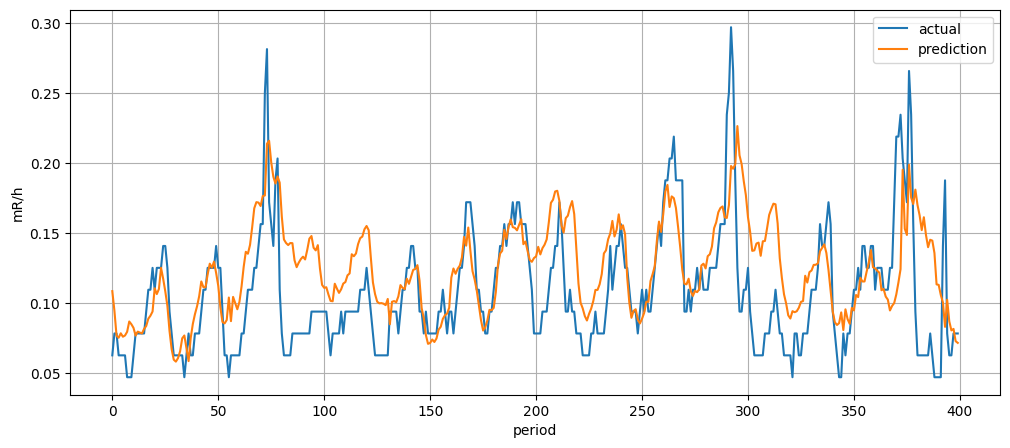

In [67]:
pred = model.predict(X_test)

plt.figure(figsize=(12,5))
plt.xlabel('period')
plt.ylabel('mR/h')
plt.plot(Y_test,label = 'actual')
plt.plot(pred, label = 'prediction')
plt.grid()
plt.legend(loc='best')
plt.show()